The aim of this notebook is to solve the linear advection equation with periodic boundary conditions (example 1.2. in the lecture notes) numerically. We will be solving it using central differences to discretize in space and a third-order Runge-Kutta method to integrate in time.

# Linear advection equation

## Initialize grid and data

We start by discretizing uniformally the domain and initializing the boundary conditions and initial conditions.

In [403]:
using Plots 
using LinearAlgebra

length = 80
x = range(0,2,length=length)
t = range(0,4, length=length)
delta_x = x[3]-x[2]
# equation coefficient 
a = 1/2#1/2
print(delta_x)
# Initial condition
u_0(x) = sin(pi*x)
# Boundary condition
u_b(t) = -sin(pi*t)

0.02531645569620253

u_b (generic function with 1 method)

Analytic solutions for latex comparison

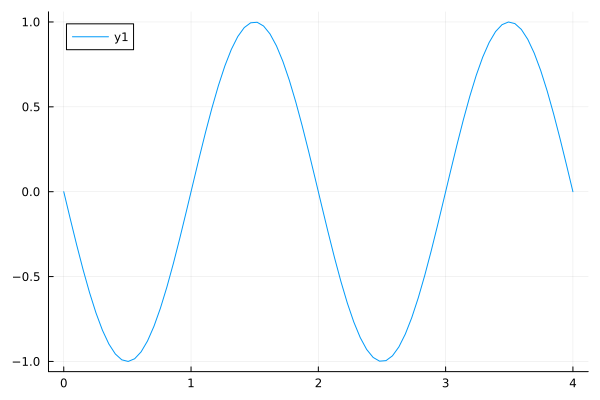

In [404]:
function analytic_solution(x,t)
    z = x-a*t
    mask_init = [if x_s-a*t_s>0 1 else 0 end for (x_s,t_s) in zip(x,t)] 
    mask_b = [if x_s==1 0 else 1 end for x_s in mask_init]
    sol = u_0(z).*mask_init + u_b(t-x/2).*mask_b
    return sol
end 
solution = analytic_solution.(0,t)
plot(t, solution)

   ## Discretization in space

Let's write down the numerical derivative of $u_0$ on the grid $x$ using a central difference scheme. Note that this can be represented by a matrix $D$. The numerical derivative $u_{x,0}$ can then be given by the inner product $D.u_0$.

In [405]:
# initialize a matrix with zeros
D = zeros(length, length)

# Set the first diagonal above the main diagonal of the matrix to 1 and the one below to -1
for i in range(1,length-1)
    D[i,i+1] = 1/2
    if i >= 2
        D[i,i-1] = -1/2
    end
end 
# Changing elements corresponding to boudnary conditions
D[1,1] = -1
D[1,2] = 1
D[length, length] = 1
D[length, length-1] = -1
delta_x = x[2]-x[1]
D /= delta_x
# Mass matrix 
M = Matrix{Float64}(I, length, length)
M[1, 1] = 1/2; M[length,length] = 1/2
M *= delta_x
# checking whether everything is correct 
M*D + D'*M
# t_L and t_R operators 
t_L = zeros(length); t_L[1] = 1
t_R = zeros(length); t_R[length] = 1

# test t_L
u_initial = u_0.(x)
t_L'*u_initial
u_b.(t)[1]


-0.0

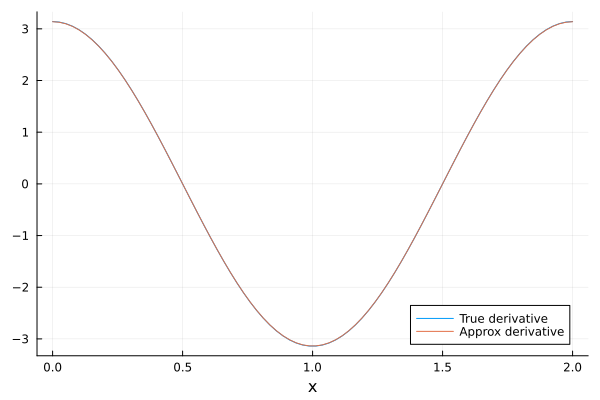

In [406]:
# test derivative of initial data 
du_0_approx = D*u_0.(x)
du_0(x) = pi*cos(pi*x)
du_0_true = du_0.(x)
plot(x, du_0_true, xlabel="x", label="True derivative")
plot!(x, du_0_approx, xlabel="x", label="Approx derivative")

## Time propoagator 

We will now implement a function to numerically compute integration over time. It is a third-order Runge-Kutta method (see lecture notes). 

In [407]:

function propagator_block(D,u,t)
    return -a*D*u + a*inv(M)*t_L*abs(u_b.(t)-t_L'*u)
end 

propagator_block (generic function with 2 methods)

In [408]:
# Set the time step size 
delta_t = 0.0001
function propagator(n_steps, u_0)
    t = 0
    for i in range(1, n_steps)
        y_1 = u_0
        y_2 = u_0 .- delta_t.*(propagator_block(y_1,t))
        y_3 = u_0 .- delta_t*0.25.*(propagator_block(y_1,t).+ propagator_block(y_2,t))
        u_0 = u_0 .- delta_t*(1/6).*(propagator_block(y_1,t).+propagator_block(y_2,t)) .- (2*delta_t/3).*(propagator_block(y_3,t))
        #u_0 = u_0 + delta_t.*propagator_block(u_0,t)  
        t += delta_t 
    end 
    return u_0
end 


propagator (generic function with 1 method)

In [421]:
# Determine transient region for specific time
steps = 210
t = steps*delta_t
x_transient = [x_s for x_s in x if x_s > a*t]
print(size(x_transient))
x_asymptotic = [x_s for x_s in x if x_s <= a*t]
x_test = x_transient
print(size(x_test))

(79,)(79,)

(79, 79)

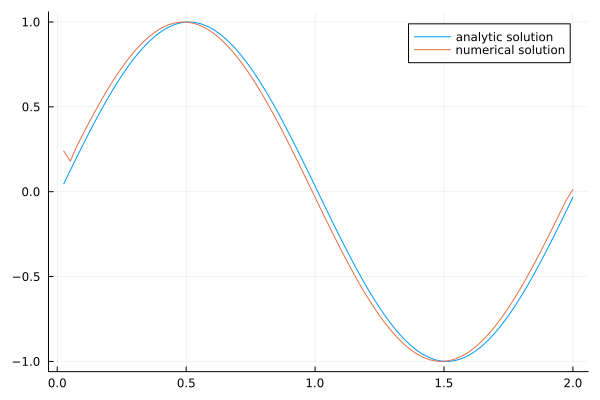

In [422]:
D = D[1:size(x_test)[1], 1:size(x_test)[1]]
M = M[1:size(x_test)[1], 1:size(x_test)[1]]
t_L = t_L[1:size(x_test)[1]]
print(size(D))
result = propagator(steps, u_0.(x_test))
#plot(x,u.(x, 5*delta_t))
analit_sol = analytic_solution.(x_test,steps*delta_t)
plot(x_test,analit_sol, label="analytic solution")
plot!(x_test, result, label="numerical solution")

In [423]:
# computing L^2 error
one = ones(size(x_transient)[1])
error = sqrt(one'*M*(analit_sol.-result).^2)

0.06792706414132173